In [1]:
#Imports
import os
from fastai.vision.all import *
set_seed(42)

In [2]:
trn_path = r"/content/drive/MyDrive/dataset/trainVal"

(3264, 2448)


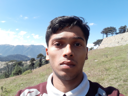

In [3]:
files = get_image_files(trn_path)
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

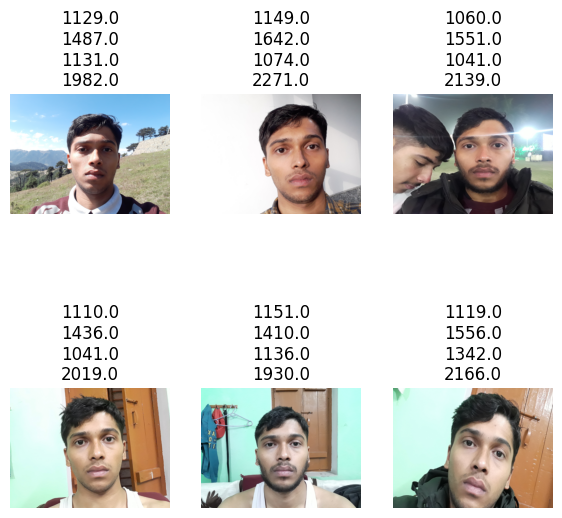

In [4]:
# Function to extract labels from the filenames
# def get_labels(file_path):
#     # Extract numbers after the first underscore
#     file_path = str(file_path)
#     file_path = file_path[0:-4]  # Get filename without extension
#     parts = file_path.split("_")[1:]  # Skip the first part (ID)
#     return list(map(float, parts))  # Convert to floats

def get_leftEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[1])  # Skip the first part (ID)

def get_leftEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[2])  # Skip the first part (ID)

def get_rightEyeR(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[3])  # Skip the first part (ID)

def get_rightEyeC(file_path):
    # Extract numbers after the first underscore
    file_path = str(file_path)
    file_path = file_path[0:-4]  # Get filename without extension
    return float(file_path.split("_")[4])  # Skip the first part (ID)

# print(get_rightEyeR(r"./dataset/train/25_1134_1801_1127_2382.jpg"))

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock, RegressionBlock, RegressionBlock, RegressionBlock),
    n_inp=1,
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=[get_leftEyeR, get_leftEyeC, get_rightEyeR, get_rightEyeC],  # Function to extract labels
    item_tfms=[RatioResize(max_sz=512)],
)

#Create the DataLoaders
dls = dblock.dataloaders(trn_path, bs=20)  # Adjust batch size as needed

# # Visualize a batch
dls.show_batch(max_n=6, figsize=(7, 7))

In [5]:
def MSELossFlat(input, target):
    return ((input - target)**2).mean()

def leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,0], leftEyeR) + MSELossFlat(input_from_model[:,1], leftEyeC)

def rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    return MSELossFlat(input_from_model[:,2], rightEyeR) + MSELossFlat(input_from_model[:,3], rightEyeC)

def net_Loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC):
    # print("A: ", leftEyeR)
    # print("B: ", leftEyeR.shape)
    # print("C:", input_from_model)
    # print("D:", input_from_model.shape)
    # print("E:", input_from_model[:,0])
    # print("F:", input_from_model[:,0].shape)
    #Normalization
    leftEyeR /= 2448
    rightEyeR /= 2448
    leftEyeC /= 3264
    rightEyeC /= 3264
    return leftEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC) + rightEye_loss(input_from_model, leftEyeR, leftEyeC, rightEyeR, rightEyeC)

# architecture = 'convnext_small_in22k' #Best Validation MSE : 5509446.000000 (10 epochs) (lr = 0.1)
# architecture = 'convnext_tiny_hnf' #Best Validation MSE : 327073 (10 epochs) (lr = 0.2)
architecture = 'regnety_006' #Best Validation MSE :  ( epochs) (lr = )

learn = vision_learner(dls, architecture, loss_func=net_Loss, n_out=4).to_fp16()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

### Don't touch beow cell

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,time
0,44.348167,13966.640625,01:21


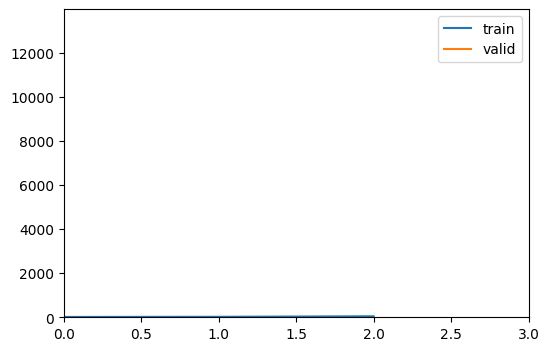

epoch,train_loss,valid_loss,time
0,109.535301,171.422943,01:02
1,79.866890,52.309265,01:05
2,67.629333,25.821918,00:59
3,55.774967,9.633780,01:01
4,47.902721,6.485072,01:00
5,42.461769,4.228101,01:00
6,38.826614,3.558474,01:00
7,35.893677,3.674769,01:01
8,32.641788,3.430438,01:11
9,29.805164,6.218809,01:10


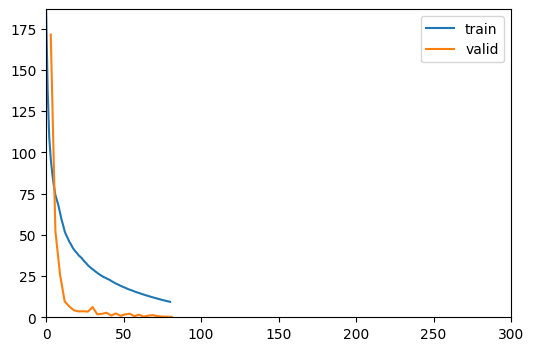

epoch,train_loss,valid_loss,time
0,109.535301,171.422943,01:02
1,79.866890,52.309265,01:05
2,67.629333,25.821918,00:59
3,55.774967,9.633780,01:01
4,47.902721,6.485072,01:00
5,42.461769,4.228101,01:00
6,38.826614,3.558474,01:00
7,35.893677,3.674769,01:01
8,32.641788,3.430438,01:11
9,29.805164,6.218809,01:10


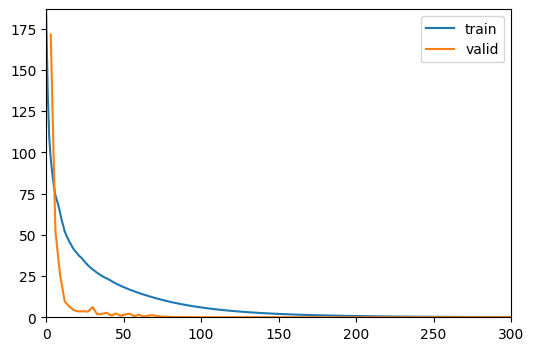

In [6]:
learn.fine_tune(100, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

### Try2 : 200 epochs

epoch,train_loss,valid_loss,time
0,39.170948,36724.714844,01:08


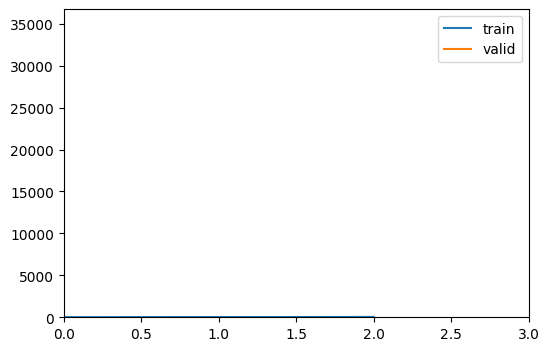

epoch,train_loss,valid_loss,time
0,101.634598,323.739624,01:04
1,77.283203,284.049683,00:59
2,63.632343,34.345913,01:01
3,54.854271,8.209269,00:59
4,47.490810,5.274714,01:00
5,42.198380,5.956923,00:55
6,38.351963,4.128855,01:01
7,35.235199,4.024694,00:55
8,32.577625,5.956184,00:58
9,30.158216,4.875501,00:57


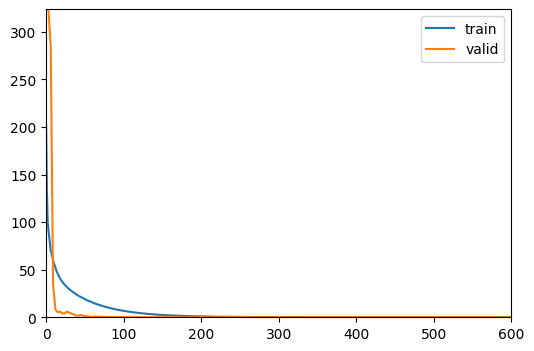

In [7]:
learn.fine_tune(200, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate

In [8]:
learn.export('finalModel.pkl')

In [17]:
# Path to the image file
img_path = "/content/drive/MyDrive/dataset/trainVal/14_1295_1779_1215_2503.jpg"

dl = learn.dls.test_dl([img_path])  # Create a DataLoader with the same transformations
predictions = learn.get_preds(dl=dl)
print(predictions)



/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


(tensor([[0.5241, 0.5699, 0.4837, 0.7910]]), None)


In [18]:
import torch

# Assuming predictions[0] contains the prediction tensor
pred_tensor = predictions[0]

# Convert the list to a tensor
multiplier_tensor = torch.tensor([2448, 3264, 2448, 3264], device=pred_tensor.device)

# Perform element-wise multiplication
result = pred_tensor * multiplier_tensor

print(result)

tensor([[1282.9955, 1860.0895, 1183.9800, 2581.9563]])


In [20]:
learn.save('finalModel_saved')

Path('models/finalModel_saved.pth')

### Train Further: 200(prev) + 20 now : 220 epochs

/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,time
0,3.084775,7.269138,00:54


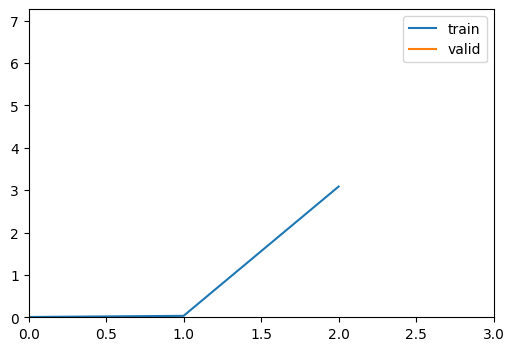

epoch,train_loss,valid_loss,time
0,4.997005,3.876623,01:01
1,3.794107,0.514035,01:01
2,3.205480,0.174773,01:01
3,2.647185,0.621148,01:01
4,2.217850,0.389780,00:59
5,1.953096,0.623359,00:57
6,1.780965,1.236337,01:03
7,1.670559,0.506066,00:59
8,1.589289,1.073056,01:00
9,1.765799,0.724558,01:00


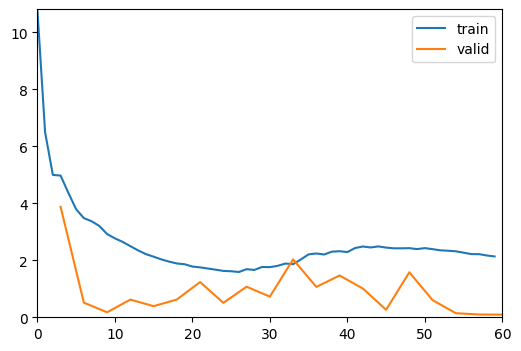

In [21]:
learn.fine_tune(20, 0.2, cbs=[
    ShowGraphCallback(),
]) #epochs and learning rate